# Tutorial of ICA applied to HD189733

This tutorial does not aim to explain the Radial Velocity (**RV**) Method and its abilities in exoplanet's detection.
Our goal is to explain how to run a **stochastic process** of ICAs to estimate the **RV** signal induced by the exoplanet over the star. 

However just to contextualize for those who are not familiar, the main idea is that the planet influences the RV of the star while orbiting around it. If there was only a planet and a star the RV's variation we can observe would be directly a consequence of the planet and what we could call $RV_{planet}$ would refered to the courbe of variation of the RV of the star induced by the planet. 

Because of what we will call **stellar activity** planet is not the only influence of RV variations, at least when we observe with spectophotographic methods. This is the main reason that motivates to process with **Independent Component Analysis (ICA)** which consists, having a set of data, to separate the dataset in independent components.

Here one component is the signal induced by the planet and the others (because it can be several sources) refer to stellar activity.

#### First of all we will need some packages to import

**Note** : Some of them have been built but you can find all on the github link?

In [12]:
pip install coroica

Note: you may need to restart the kernel to use updated packages.


In [13]:
from IPython. display import Latex
%load_ext autoreload
%autoreload 2
import autograd.numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
sys.path.append(os.getcwd()+'/ICA') # to use personal ICA package
from utils import SNR, standardize, plot_2D_distrib, mean, whiten
from core import CustomICA, PostProcess
from heuristics import sk_FastICA, jadeR, V_manifold_optim, A_manifold_const, FOBI, partial_FastICA, PCA
from scipy.optimize import minimize
from astropy.timeseries import LombScargle 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Pre-processing

The first thing to do is to open our set of datas. \
In our case datas of the star HD189733.



In [14]:
planet = 'HD189733'
period = 2.218573
#the period correspond to?

os.listdir('data/'+planet)

['SOPHIE.2007-07-30T01_37_43.460_ccf_G2_A.tbl',
 'SOPHIE.2007-08-01T20_58_10.957_ccf_G2_A.tbl',
 'SOPHIE.2007-08-04T01_33_27.989_ccf_G2_A.tbl',
 'SOPHIE.2007-07-16T20_50_11.200_ccf_G2_A.tbl',
 'SOPHIE.2007-07-24T20_46_01.816_ccf_G2_A.tbl',
 'SOPHIE.2007-07-21T02_19_17.827_ccf_G2_A.tbl',
 'SOPHIE.2007-07-29T21_34_21.900_ccf_G2_A.tbl',
 'SOPHIE.2007-07-21T21_55_30.310_ccf_G2_A.tbl',
 'SOPHIE.2007-07-27T02_12_59.907_ccf_G2_A.tbl',
 'SOPHIE.2007-07-26T20_49_14.427_ccf_G2_A.tbl',
 'SOPHIE.2007-07-30T21_31_39.525_ccf_G2_A.tbl',
 'SOPHIE.2007-07-21T20_29_45.906_ccf_G2_A.tbl',
 'SOPHIE.2007-07-19T02_40_21.744_ccf_G2_A.tbl',
 'SOPHIE.2007-08-18T20_35_39.676_ccf_G2_A.tbl',
 'SOPHIE.2007-07-25T01_52_13.263_ccf_G2_A.tbl',
 'SOPHIE.2007-07-18T02_31_34.642_ccf_G2_A.tbl',
 'SOPHIE.2007-08-20T20_29_35.476_ccf_G2_A.tbl',
 'SOPHIE.2007-07-22T21_11_29.817_ccf_G2_A.tbl',
 'SOPHIE.2007-08-05T19_51_02.334_ccf_G2_A.tbl',
 'SOPHIE.2009-09-17T21_34_14.501_ccf_G2_A.tbl',
 'SOPHIE.2007-08-03T21_21_22.544_ccf_G2_

In our case, the command returns 
'Log_HD189733.dat' and then a series of files of the form 'SOPHIE.20...ccf_G2_A.tbl'

We can open these files to see what it contains.

In [15]:
metadata = pd.read_csv('data/'+planet+'/Log_'+planet+'.dat', sep='\s+', usecols=['#', 'File', 'Name', 'Date', '(MJD)'])
metadata.columns = ['File Name', 'Date (MJD)', 'Phase', 'RV obs', 'RV theo']
metadata.drop_duplicates(inplace=True)
#we change the names of column here because the names are note right aligned

metaccf = pd.read_csv('data/'+planet+'/SOPHIE.2007-06-09T01_19_05.904_ccf_G2_A.csv', sep='\s+', usecols=[ 'order', 'maxcpp', 'nlines', 'contrast', 'RV', 'sig'])
#Here we opened only the first file with the form "SOPHIE...."

Now before starting to run an ICA let's talk about the datas and see if there are some outliers or weirds datas.



### Focus on metada
Let's explain what is the meaning of each column of metada


In [16]:
metadata

,File Name,Date (MJD),Phase,RV obs,RV theo
0,2007-06-09T01_19_05.904,54260.053056,-9.261613,-2.2724,-0.0149
1,2007-06-13T01_59_57.950,54264.081470,-7.445847,-2.4420,-0.1932
2,2007-07-13T00_09_04.019,54294.002581,6.040783,-2.0664,0.1983
3,2007-07-16T20_50_11.200,54297.864479,7.781494,-2.2063,0.0403
4,2007-07-17T02_24_01.489,54298.096308,7.885989,-2.0992,0.1546
...,...,...,...,...,...
58,2007-08-23T23_06_55.822,54335.959421,24.952394,-2.0569,0.1959
59,2009-06-21T02_07_31.731,55003.083102,325.651483,-2.3503,-0.1189
60,2009-07-20T02_14_35.563,55032.088009,338.725144,-2.2838,-0.0319
61,2009-07-28T21_55_29.751,55040.908090,342.700704,-2.3068,-0.0625


The first interesting column **'Data(MJD)' (Modified Julian Date)** corresponds to the time of the different measures.

The columns **'RV obs'** and **'RV theo'** correspond to the **Radial Velocity observed** (by observed means calculated) and **Radial Velocity theoric** of the planet's signal induced over the star. We see that it does not seem to match but do not forget that datas are not normalized yet. 
The other interesting thing to comment here is that we know the RV theo, which should not be possible if we are seeking for an exoplanet we do not know yet.

Finally the column **'phase'** refers to ?

So first Let's create our list of time and observe it.

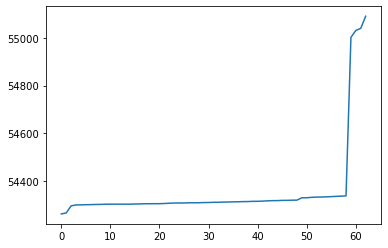

In [17]:
timeline = np.array(metadata['Date (MJD)'])
plt.plot(timeline)

we can see some discontinuity of measurements over the time, at the beginning and the end. In the following we will discard these datas from our study
This might appears more concrete with this graphic.

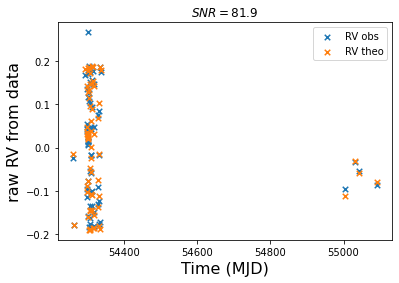

In [18]:
#Normalize the datas
obs = standardize(np.array(metadata['RV obs']))
theo = standardize(np.array(metadata['RV theo']))

plt.figure()
plt.scatter(timeline, obs, marker='x', s=30, label='RV obs')
plt.scatter(timeline, theo, marker='x', s=30,label='RV theo')
plt.xlabel('Time (MJD)', fontsize=16)
plt.ylabel('raw RV from data', fontsize=16)
plt.title(r'$SNR='+'{:.1f}'.format(SNR(theo, obs))+'$')
plt.legend()
plt.show()

What we did here is to plot the $RV_{theo}$ and $RV_{obs}$ that we get from the ***metadafile*** over the time.

The **SNR** (Signal to Noise Ratio) is our tool to measure the likelihood between our observation and the theoric measure.
 
$$SNR = \frac{\sigma^{2}_{signal}}{\sigma^{2}_{noise}}$$

Here $\sigma^{2}$ refers to the variance and noise is the difference between the theoric signal and the observed one. 
So basically we are looking for the higher **SNR** possible.

### Focus on the differents metaccf

Let's explain the meaning of each column of metaccf

In [19]:
metaccf

,order,maxcpp,nlines,contrast,RV,sig
0,-----,------,------,--------,--,---
1,0,145,198,12.4,-2.8165,3.5293
2,1,188,197,16.0,-2.3829,3.2486
3,2,300,217,27.6,-2.1448,3.3984
4,3,343,204,29.0,-1.9822,3.1773
5,4,415,210,32.8,-2.2213,3.2901
6,5,454,213,29.2,-2.1529,3.2294
7,6,511,197,31.2,-2.1627,3.6475
8,7,546,181,32.4,-2.2412,3.8413
9,8,599,176,31.8,-2.1218,3.2937


The first interesting column is **"orders"**, which refers obviously to the orders from the charge-coupled device **(CCD)** captors, let's resume it as a parameter of our modelisation for Radial velocities of the planet. 

For each order we have a maximum number of count per pixel (**'maxcpp'**), a number of lines (**'nblines'**) and a **'contrast'** which allow to calculate an estimation of **'RV'** with an error **'sigma'**

**Remark** : Don't get confused betweend **'RV' obs from the metadata file which is a valued obtained by a mean and ponderation for each value of RV per order we can get with a metaccf file.

To sum it up, for each time (from **MJD**) we get a **CCF** file with 39 values of RV and our goal is to modelise the evolution of RV over time with such datas.

Let's open all the CCF files and make some comments.

In [20]:
n = len(timeline)
d = 39 # number of orders used

print("Working with n =",n,"time measures and d =",d,"spectral dimensions")

rv = []
sigma = []

for i, raw in metadata.iterrows():
    df = pd.read_csv('data/'+planet+'/SOPHIE.'+raw['File Name']+'_ccf_G2_A.tbl', 
                     sep='\s+', 
                     skiprows=[1,], 
                     index_col='order')
    rv.append(list(df['RV']))
    sigma.append(list(df['sig']))
    # print(df)
    # print(i)
    # print(raw)
    # print(rv)
    # print(sigma) 
    
rv = np.array(rv).T
sigma = np.array(sigma).T
assert rv.shape == (d, n)

#for instant in range(n):
    #plt.figure()
    #for order in range(d):
        
       # plt.title(str(instant )+ ' instant '+str(timeline[instant]))
       # plt.xlabel('order')
       # plt.ylabel('radial velocity (km/s)')
       # plt.errorbar(order, rv[order, instant], sigma[order, instant], fmt='o')
    #plt.show()

Working with n = 63 time measures and d = 39 spectral dimensions


We can see that for every files the orders 30 and 38 give wrong data, so we will delete them. 
As seen previously we will also delete the times from 60 to 63, but we might have to check for others wrong data, so let's take a closer look. 

The instant 3 and 17 seem to have wrong data for the order 0 so let's delete them.


In [21]:
#new rv,sigma
rv = np.delete(rv, [30, 38], 0)
sigma = np.delete(sigma, [30, 38], 0)

print('There are {} orders in the big set.'.format(len(rv)))
ind = np.ones(len(timeline), dtype=bool)
ind[3] = False
ind[17] = False

# Select times in the big set
ind *= (timeline > 54280) & (timeline < 54350)


print('There are {} points in the big set.'.format(sum(ind)))

#new timeline
newtimeline = timeline[ind]

rv = rv[:,ind]
sigma = sigma[:,ind]



d, n = rv.shape
print("Working with n =",n,"time measures and d =",d,"spectral dimensions")


There are 37 orders in the big set.
There are 55 points in the big set.
Working with n = 55 time measures and d = 37 spectral dimensions


Let's keep the 55 interesting values of **RV theo** and **RV obs** and recalculate the SNR.

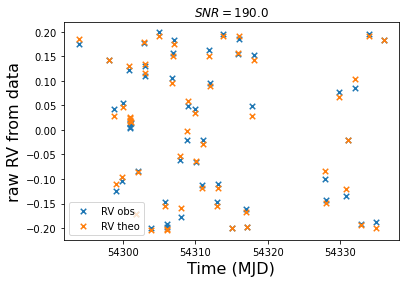

In [22]:
newtheo = np.array(metadata['RV theo'])[ind]
newtheo = standardize(newtheo)

newobs =np.array(metadata['RV obs'])[ind]
newobs = standardize(newobs)

plt.figure()
plt.scatter(newtimeline, newobs, marker='x', s=30, label='RV obs')
plt.scatter(newtimeline, newtheo, marker='x', s=30,label='RV theo')
plt.xlabel('Time (MJD)', fontsize=16)
plt.ylabel('raw RV from data', fontsize=16)
plt.title(r'$SNR='+'{:.1f}'.format(SNR(newtheo, newobs))+'$')
plt.legend()
plt.show()



Finally we want to work with normalize. To do so we use the function **mean** from the package **utils** which take X (d,n) and return $X-X_{avg}$(d,) where $X_{avg}(d,)$ is the vector of the average of orders over time $n$.

In [23]:
rv = mean(rv)[0]


In [24]:
print((rv.dot(rv.T)).shape)

(37, 37)


## About ICA
So now that our **rv** matrix has been post-procesed we can work. In the following we will call it $X$.
The idea of ICA is the same as the problem of Blind Separate Sources (BSS). 

The key assumption is that $X$ is a linear mixture of a vector of underliying sources $S$ where we suppose that each component of $S$ are independent. 

Thus the problem can be summarize as $$X = AS$$ where A and S are unknown and such that each component of $S$ are independent. 

Therefore we will look for $W$ an approximation of $A^{-1}$ such that $WX = \hat S$ a good estimator of S.

**Remark** : Here we are not facing a complicated Inverse Problem where the aim is to find and estimation of $A^{-1}$. Indeed not only $A$ is unknown but also $S$ !

#### A brief remind of PCA
Let's say we have our dataset $X$ where each row is all the measurement over time from a parameter and each column is all the parameter's measurement for a particular time.
We can define the covariance matrix $$C_X = \frac{1}{n} X X^T $$

- Diagonal terms of $C_X$ are the variance of each parameter.
- Off-diagonal terms are the covariance between parameters.

The idea of PCA is to find new parameters which are all uncorrelated which means a change of basis where off-diagonal terms of the new covariance matrix are null.
This can be done easily since $C_X$ is a square symmetric matrix. Spectrum Theorema ensures that $C_X$ can be diagonalized in an orthonormal basis P such that :
$$  PC_XP^T = D$$ where 
- $D$ is diagonal and $P$ is a matrix which each row $p_i$ is a eigenvector  
- $i^{th}$ diagonal value is the variance of the new parameter $p_i$


#### A Strategy for Solving ICA
Before to run our ICA we want to simplify the problem as much as we can. We will forget $S$ and focus on $A$.
Let's say we have a Singular Value Decomposition of $A$ : $$A = U \Sigma V^T$$ 
Where $U$,$V$ orthogonal matrix and $\Sigma$ diagonal.
Then $W = V \Sigma^{-1} U^T$

Now if we come back to the covariance matrix $C_X$, assuming that $X$ already meaned, whe have:
$$C_X = AS(AS)^T$$ 
Which gives after developing.
$$C_X = U\Sigma V^T SS^T V\Sigma U^T$$

With the assumption of independence, $SS^T = I$ and finally $$C_X = U\Sigma^2 U^T$$

By indentifying this expression with the one we get from the PCA we can note the correspondance :
 $$D^{\frac{1}{2}}=\Sigma$$
 $$ P = U^T$$

Finally if we note $$X_w = D^{-\frac{1}{2}}PX$$ 

We are now looking for a rotation matrix $V$ that gives the good estimator : $$\hat S = VX_w$$
where $X_w$ is such that : $$X_w X_w ^T = I$$





### PCA Application for solving ICA
To compute PCA there are already numerous aglorithms on Python. Here we created a simple one which use the function **whiten** from package **utils**.


The function **whiten** does exactly what is described above. Taking $X$ (supposed already meaned) and returning $X_w$, $D^{-\frac{1}{2}}P$, $(D^{-\frac{1}{2}}P)^{-1}$ and the list of eigenvalues.

Let's compute and see the eigenvalue cascade.

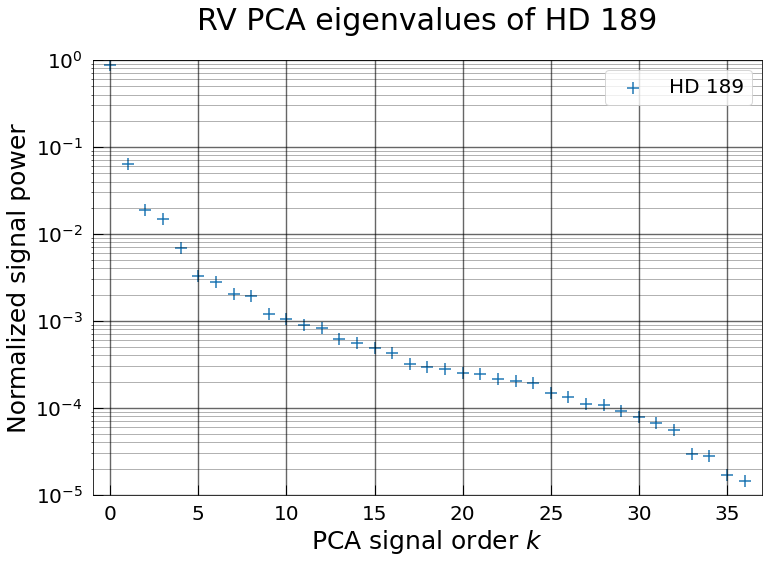

In [25]:
rv_w, Whiten_mat, Whiten_mat_inv, eigs_RY_2 = whiten(rv)
eigs_RY_2 /= np.sum(eigs_RY_2)

plt.figure(figsize=(12,8))
plt.yscale('log')
plt.grid(True, which='minor', linewidth=0.5, color='black', alpha=0.6)
plt.grid(True, which='major', linewidth=1.4, color='black', alpha=0.6)
plt.ylim((10**-5, 10**0))
plt.xlim(-1,37)
plt.scatter(range(len(rv_w)), eigs_RY_2, marker='+', s=150, linewidths=1, label='HD 189', alpha=1)
plt.tick_params(length=10, width=1, direction='in', pad=10, labelsize=20)
plt.legend(fontsize=20)
plt.xlabel(r'PCA signal order $k$', fontsize=25)
plt.ylabel(r'Normalized signal power', fontsize=25)
plt.title(r'RV PCA eigenvalues of HD 189', fontsize=30, pad=30)
#plt.savefig('PCA_HD189_eigenvalues.png', dpi=200)
plt.show()

We can see that $PCA_1$ represents $90 \%$ of the full signal power
Let's see what **SNR** we can get with a first approximation on $PCA_1$. 

- $PCA_1$: the strongest component raised by PCA:
$$PCA_1 = \alpha . RV_w[0,:]$$
To get the best $\alpha$ we can use our knowledge of $RV_{theo}$. We know that the best projection on $PCA_1$ is the orthogonal projection. From this observation we get the following equations for $\alpha$.
$$Cov(PCA_1, RV_{theo}) = Var(RV_{theo}) \iff \alpha . Cov(RV_w[0,:], RV_{theo})=Var(RV_{theo}) \iff \alpha = \frac{Var(RV_{theo})}{Cov(RV_w[0,:], RV_{theo})}$$

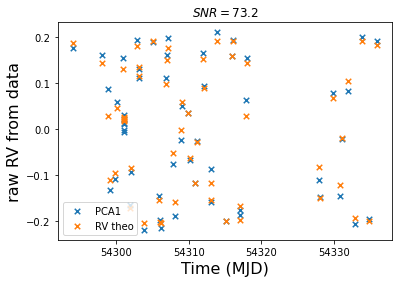

In [26]:
alpha = np.array(metadata['RV theo'])[ind].dot(np.array(metadata['RV theo'])[ind]) \
        * 1 / rv_w[0,:].dot(np.array(metadata['RV theo'])[ind])
PCA1 = rv_w[0,:]*alpha

plt.figure()
plt.scatter(newtimeline, PCA1, marker='x', s=30, label='PCA1')
plt.scatter(newtimeline, newtheo, marker='x', s=30,label='RV theo')
plt.xlabel('Time (MJD)', fontsize=16)
plt.ylabel('raw RV from data', fontsize=16)
plt.title(r'$SNR='+'{:.1f}'.format(SNR(standardize(newtheo), standardize(PCA1)))+'$')
plt.legend()
plt.show()


We can compare this value with the one we get from a naive approximation averaging orders.

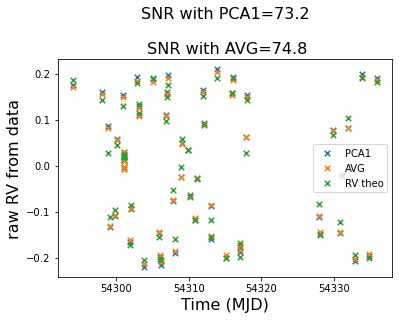

In [27]:
obs_avg = np.average(rv, axis=0)

plt.figure()

plt.scatter(newtimeline, PCA1, marker='x', s=30, label='PCA1')
plt.scatter(newtimeline, obs_avg, marker='x', s=30, label='AVG')
plt.scatter(newtimeline, newtheo, marker='x', s=30,label='RV theo')
plt.xlabel('Time (MJD)', fontsize=16)
plt.ylabel('raw RV from data', fontsize=16)
plt.title(r'SNR with PCA1='+'{:.1f}'.format(SNR(standardize(newtheo), standardize(PCA1)))+  '\n \n SNR with AVG='+'{:.1f}'.format(SNR(standardize(newtheo), standardize(obs_avg))) , fontsize=16)

plt.legend()
plt.show()

We can see that **Averaging** here is better than a **PCA** this is another reason that motives us to run an ICA. Indeed we are not seeking for powerfuls components but for qualitative ones.

#### A remark about our theoretical knowledge

As mentionned previously, one can be a little bit surprised that our method uses the knowledge of $RV_{theo}$. This is clearly a limit for our modelisation that we will try to overcome at the end. But for now, let's continue and try to run an ICA using the best **proxy** we get from **Averaging** method and which will be named $RV_{proxy}$ in the following.



### Turning ICA in an optimization problem

So as we've seen previously the problem is now reduced to find the good $V$ such that 
$$\hat S =VX_w$$

To do so we have to use our assumption of independence. We are looking for a rotation that remove every higher-order correlation such that $\hat S$ is statistically independent. 

Therefore we need to introduce a measure of independence. This can be done using information theory. 

The ***multi-information*** (*generalization of mutual information*) is an appropriate tool. If $\textbf{y}$ is a distribution of multiple variables $y_i$ :
$$ I(\textbf{y}) = \int P(\textbf{y}) log_2 \frac{P(\textbf{y})}{\prod_{i} P(y_i)} \,\mathrm d\textbf{y} $$

I is a positive function that reaches a minimum of zero if and only if all variables are statistically independent. 

**Remark :** If $P(y) = \prod_{i} P(y_i)$ we get $log_2(1) = 0$ and $I(y) = 0$.

So now we get a condition for our search on $V$ : Find V which minimizes $I(VX_w)$. 

Now we have an optimization problem we can develop algorithms to reach the solution. In our package **ICA** we have several algorithms that solve the probleme with differents approachs. And also a personal implementation **V_manifold_optim** in **heuristics** (but I CAN'T IMPLEMENT IT). 

The particularity of this personal approach is that it uses properties of **special orthogonal group** $SO(\mathbb{R})$ and looks for a V in this subspace instead of the whole space of *orthogonal matrices* using a **conjugate gradient's method.**


#### How to know what component is $RV_{planet}$

To find the best candidate for the planet signal among sources ($\hat S_1,...,\hat S_l$) we just select the more correlated one with our proxy : 
$$Find(\hat S, {RV}_{proxy}) = argmax_{{RV}_{signal} \in (\hat S_1,...,\hat S_l)} Cov(RV_{signal},RV_{proxy})$$

A scaling factor has to be used to recover entirely the ICA estimated planet signal out of the best estimated source. 


$$CorrectedFind(\hat S, {RV}_{proxy}) = \frac{Var({RV}_{proxy})}{Cov(Find(\hat S, {RV}_{proxy}))}Find(\hat S, {RV}_{proxy})$$

### The concept of the Hope Limit

This part is the main issue of this approach. So in this part we will accept that we have a proxy.

Now that we have an algorithm which can run an ICA we face a dimensional problem. Indeed this was not explicitely mentionned before but we face a dimensionnal problem. 

If we throw the 37 signals into the ICA it will fail because the dimension is to high and freezes the convergence. 
Therefore we have to look for less signals without losing too much information. This can be done, using our proxy.

In this particular case where we know the theoric signal we will use it because it must perform better.

So we define a new quantity **HopeLim** which is the best **SNR** we can get reducing the dimension.

\begin{equation}
\text{HopeLim} (X_1, \dots, X_r) = \sup_{Y \in \text{Vect}(X_1, \dots, X_r)} \text{SNR}({RV}_{pl}, Y)
\end{equation}

This what we have using all dimensions

In [28]:
sol = minimize(lambda combs: np.sum((combs.dot(rv)-standardize(theo[ind]))**2), np.ones(len(rv)))
print('\nHopeLim =', SNR(standardize(theo[ind]), sol.x.dot(rv)))


HopeLim = 525.2440349919149


Here is a little code to reduct dimension (2 ways to do it)

In [29]:
def random_dim_reductor(d, d_out):
    red = np.zeros((d_out, d))
    if not (d//d_out)*d_out == d:
        resid = d - (d//d_out)*d_out
        d -= resid
        print('Warning: cropping ', resid,' sources')
    choices = np.random.choice(range(d), (d_out,d//d_out), replace=False)
    for row in range(d_out):
        red[row, choices[row]] = 1
    return red

def avg_dim_reductor(d, d_out):
    red = np.zeros((d_out, d))
    for row in range(d_out):
        red[row, row*(d//d_out):(1+row)*(d//d_out)] = 1
    return red

For each dimension reduction we can compute the **HopeLim**.

This gives us an idea of the optimum SNR we can reach while reductioning dimension.

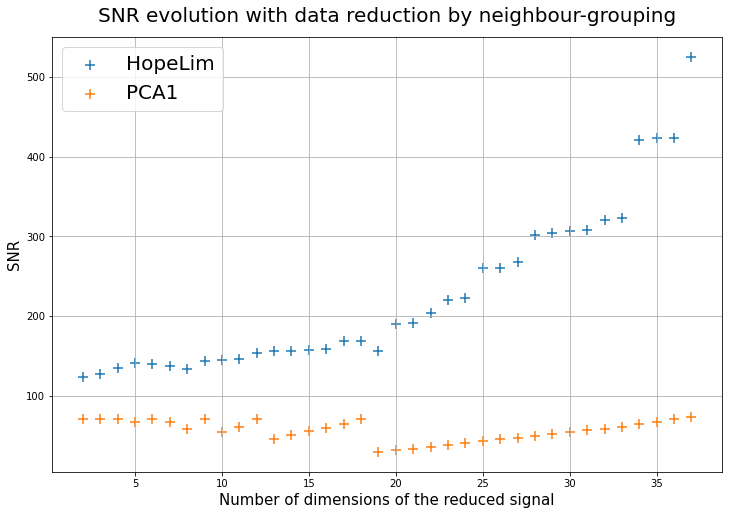

In [30]:
dims = range(2, d+1)
hopes = []
PCAs_red1 = []

for d_out in dims:
    #print("\nReducting to ", d_out, " dims:")
    red = avg_dim_reductor(d, d_out)
    rv_w, Whiten_mat, Whiten_mat_inv, eigs_RY_2 = whiten(red.dot(rv))
    sol = minimize(lambda combs: np.sum((combs.dot(rv_w[:d_out,:])-standardize(theo[ind]))**2), np.ones(len(rv_w[:d_out,:])))
    hope = SNR(standardize(theo[ind]), sol.x.dot(rv_w[:d_out,:]))
    PCA_red1 = SNR(standardize(theo[ind]), standardize(np.sign(standardize(theo[ind]).dot(rv_w[0,:]))*rv_w[0,:]))
    hopes.append(hope)
    PCAs_red1.append(PCA_red1)
    #print('---- HopeLim =', hope)
    #print('---- PCA1 =', PCA_red1)

plt.figure(figsize=(12,8))
plt.scatter(dims, hopes, marker='+', s=100, label='HopeLim')
plt.scatter(dims, PCAs_red1, marker='+', s=100, label='PCA1')
plt.legend(fontsize=20)
plt.grid(True)
plt.xlabel('Number of dimensions of the reduced signal', fontsize=15)
plt.ylabel('SNR', fontsize=15)
plt.title('SNR evolution with data reduction by neighbour-grouping', fontsize=20, pad=15)
plt.show()

### Analyze of ICA through one run

Now that we know how to reduce dimension we can run an ICA. Let's try for a reduced dimension d = 4.

**Remark** : Choice is arbitraty and will be made automatically using stochastic ICA.

In [50]:
i = 0
L = []
while i <50:
    
    d_out = 2
    red = avg_dim_reductor(d, d_out)
    rv_w, Whiten_mat, Whiten_mat_inv, eigs_RY_2 = whiten(red.dot(rv))

    customICA = CustomICA(rv_w,
                      noise_fraction=10/100,
                      verbose=False, 
                      constraints=['less-entropy'],
                      schedule=[sk_FastICA],
                      schedule_kwargs=[{'max_iter':1000, 'algorithm':'deflation'}],
                      skip_exception=False)

    S_hat = customICA.result_traceback[-1]['S']
    objective = standardize(newtheo)
    sol = minimize(lambda combs: np.sum((combs.dot(S_hat)-objective)**2), np.ones(len(S_hat)))
    best_ind = np.abs(sol.x).argmax()
    L.append(SNR(objective, standardize(np.sign(sol.x[best_ind])*S_hat[best_ind])))
    i += 1
    
m = np.average(L)
print(m)


101.46605753473412


SNR = 123.59930356024266


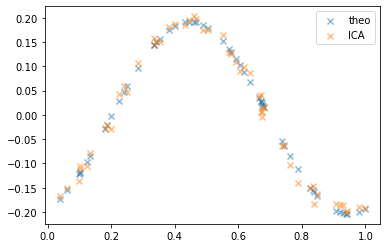

In [51]:
plt.scatter(newtimeline/period % 1, standardize(theo[ind]), label='theo', marker='x', alpha=0.5)
plt.scatter(newtimeline/period % 1, standardize(np.sign(sol.x[best_ind])*S_hat[best_ind]), label='ICA', marker='x', alpha=0.5)
plt.legend()

print('SNR = '+ str(SNR(objective, standardize(np.sign(sol.x[best_ind])*S_hat[best_ind]))))

At this point, the ICA does not seem interesting because the SNR we get is lower than the one from Average Method. 

But our idea is to improve our model by running a lot of ICA with different choice of reduction dimension and to average, keeping the signals that lead to a good SNR.

### Using stochastic ICA with post-processing

Computing with neighbour-grouping in  2  dimensions...


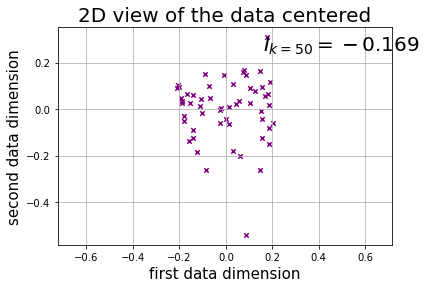

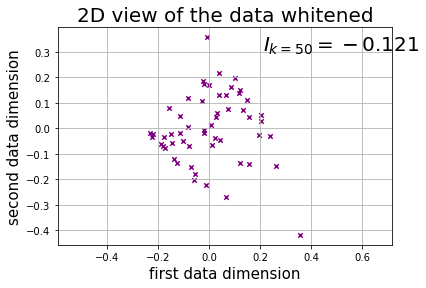


Step 0: proceeding to sk_FastICA ...

A:
 [[-0.00102295  0.99999948]
 [ 0.99999948  0.00102295]]
S average:  [5.04646829e-19 1.00929366e-18]
noise average:  [-6.91918114e-19  4.33680869e-19]
S cov:
 [[ 1.00000000e+00 -1.08420217e-15]
 [-1.08420217e-15  1.00000000e+00]]
I_{k=50}(S): -0.16880780487677383
noise cov:
 [[2.97368213e-32 9.58822530e-33]
 [9.58822530e-33 1.54958367e-32]]
X cov:
 [[ 1.00000000e+00 -1.08940634e-15]
 [-1.08940634e-15  1.00000000e+00]]
cov(AS,noise):
 [[ 7.80480634e-17 -1.22516605e-16]
 [ 1.21213510e-18 -7.81983576e-17]]


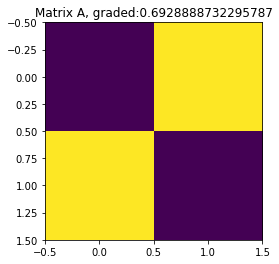

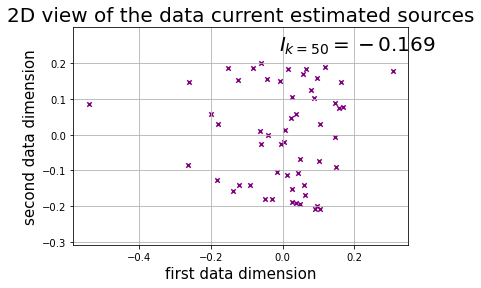


Step 1: proceeding to sk_FastICA ...

A:
 [[-0.99854595  0.05390725]
 [-0.05390725 -0.99854595]]
S average:  [-1.00929366e-18  1.76626390e-18]
noise average:  [5.32244703e-20 1.43508942e-18]
S cov:
 [[ 1.00000000e+00 -1.06858966e-15]
 [-1.06858966e-15  1.00000000e+00]]
I_{k=50}(S): -0.17573506001281647
noise cov:
 [[ 7.43999027e-32 -4.62718519e-33]
 [-4.62718519e-33  3.25079193e-32]]
X cov:
 [[ 1.00000000e+00 -1.08940634e-15]
 [-1.08940634e-15  1.00000000e+00]]
cov(AS,noise):
 [[ 2.61180183e-16  3.56873302e-18]
 [-1.17014474e-17 -1.36582053e-16]]


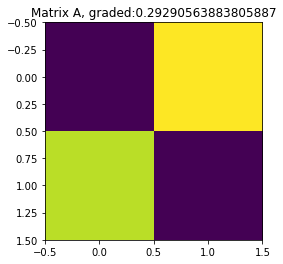

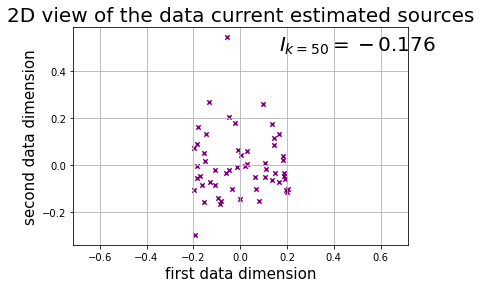


Step 2: proceeding to sk_FastICA ...

A:
 [[-0.00174193  0.99999848]
 [ 0.99999848  0.00174193]]
S average:  [5.04646829e-19 3.02788098e-18]
noise average:  [2.94508736e-18 4.17910656e-19]
S cov:
 [[ 1.00000000e+00 -1.09461051e-15]
 [-1.09461051e-15  1.00000000e+00]]
I_{k=50}(S): -0.16895009641577863
noise cov:
 [[ 6.28496102e-32 -3.31365121e-32]
 [-3.31365121e-32  6.36974861e-32]]
X cov:
 [[ 1.00000000e+00 -1.08940634e-15]
 [-1.08940634e-15  1.00000000e+00]]
cov(AS,noise):
 [[-2.32418264e-16  5.78358010e-17]
 [ 1.77595956e-16  1.47766419e-16]]


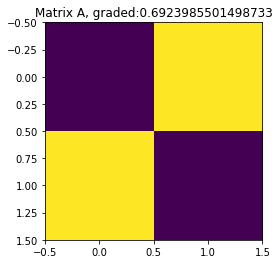

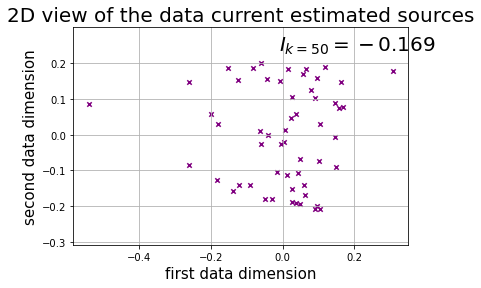


Step 3: proceeding to sk_FastICA ...

A:
 [[-0.0022349 -0.9999975]
 [ 0.9999975 -0.0022349]]
S average:  [5.04646829e-19 5.04646829e-19]
noise average:  [ 1.39172133e-18 -8.67361738e-20]
S cov:
 [[1.0000000e+00 1.0564466e-15]
 [1.0564466e-15 1.0000000e+00]]
I_{k=50}(S): -0.16904356829821365
noise cov:
 [[ 1.53686662e-32 -2.47299561e-33]
 [-2.47299561e-33  2.37662012e-32]]
X cov:
 [[ 1.00000000e+00 -1.08940634e-15]
 [-1.08940634e-15  1.00000000e+00]]
cov(AS,noise):
 [[-3.63070612e-17 -8.15558507e-17]
 [ 5.52308517e-17  2.89356185e-17]]


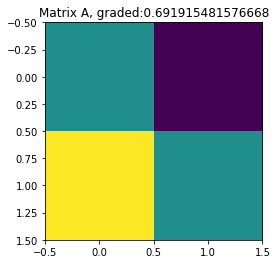

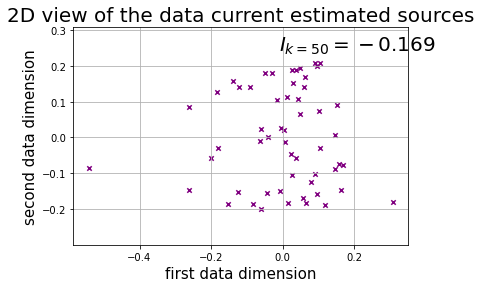

Computing with neighbour-grouping in  3  dimensions...

Step 0: proceeding to sk_FastICA ...

A:
 [[ 0.98369133  0.17687788  0.03264315]
 [-0.16573555  0.9618742  -0.21755401]
 [ 0.0698791  -0.20859586 -0.97550227]]
S average:  [-1.51394049e-18 -2.46015329e-18 -3.02788098e-18]
noise average:  [-3.03970864e-18  3.66657462e-18  6.70234070e-20]
S cov:
 [[ 1.00000000e+00 -2.71484224e-16  3.69582837e-15]
 [-2.71484224e-16  1.00000000e+00  1.24715776e-15]
 [ 3.69582837e-15  1.24715776e-15  1.00000000e+00]]
I_{k=50}(S): -0.4863267830351483
noise cov:
 [[6.85319311e-32 1.96264811e-33 4.83919564e-33]
 [1.96264811e-33 1.01986574e-31 4.15053206e-32]
 [4.83919564e-33 4.15053206e-32 4.45794358e-32]]
X cov:
 [[ 1.00000000e+00 -1.17787724e-15 -3.66026653e-15]
 [-1.17787724e-15  1.00000000e+00  8.16621076e-15]
 [-3.66026653e-15  8.16621076e-15  1.00000000e+00]]
cov(AS,noise):
 [[ 2.32908414e-16 -2.91175692e-17 -7.81509761e-18]
 [-1.58765163e-17 -9.60224165e-17 -2.57502145e-16]
 [ 1.12977033e-17  7.150

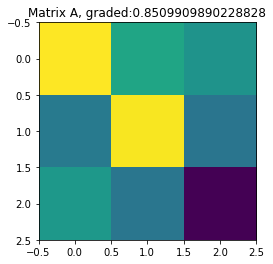


Step 1: proceeding to sk_FastICA ...

A:
 [[-0.36910503 -0.00777537  0.92935516]
 [-0.21576586 -0.97192687 -0.09382566]
 [-0.90399478  0.23515464 -0.35706544]]
S average:  [ 1.26161707e-18 -2.77555756e-18 -4.54182146e-18]
noise average:  [-2.62968309e-18  3.54041291e-18  6.66291517e-19]
S cov:
 [[ 1.00000000e+00 -6.20163643e-16  2.32452946e-15]
 [-6.20163643e-16  1.00000000e+00  2.60208521e-17]
 [ 2.32452946e-15  2.60208521e-17  1.00000000e+00]]
I_{k=50}(S): -0.5532006088505197
noise cov:
 [[1.30779300e-31 3.90186208e-32 9.45169638e-32]
 [3.90186208e-32 7.08410311e-32 1.97344197e-32]
 [9.45169638e-32 1.97344197e-32 1.05584676e-31]]
X cov:
 [[ 1.00000000e+00 -1.17787724e-15 -3.66026653e-15]
 [-1.17787724e-15  1.00000000e+00  8.16621076e-15]
 [-3.66026653e-15  8.16621076e-15  1.00000000e+00]]
cov(AS,noise):
 [[-3.34415420e-16  3.59725727e-17  1.00164295e-16]
 [-4.91373971e-17  1.82202500e-16  1.59920027e-16]
 [-2.95796307e-16  6.90793932e-17 -4.76036005e-17]]


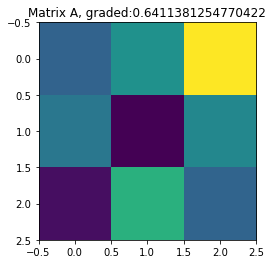


Step 2: proceeding to sk_FastICA ...

A:
 [[ 0.01307311 -0.99960469  0.02489106]
 [ 0.97516713  0.00724164 -0.22135184]
 [-0.22108408 -0.0271667  -0.9748763 ]]
S average:  [-2.27091073e-18  1.00929366e-18 -1.26161707e-18]
noise average:  [ 1.03294898e-18  4.86511084e-18 -2.23542775e-18]
S cov:
 [[ 1.00000000e+00  3.38271078e-16  4.90493063e-16]
 [ 3.38271078e-16  1.00000000e+00 -3.90833199e-15]
 [ 4.90493063e-16 -3.90833199e-15  1.00000000e+00]]
I_{k=50}(S): -0.49451531565246
noise cov:
 [[ 2.78155783e-32  1.14085805e-32 -1.67555050e-33]
 [ 1.14085805e-32  2.19592009e-31 -8.19685650e-32]
 [-1.67555050e-33 -8.19685650e-32  3.63904719e-32]]
X cov:
 [[ 1.00000000e+00 -1.17787724e-15 -3.66026653e-15]
 [-1.17787724e-15  1.00000000e+00  8.16621076e-15]
 [-3.66026653e-15  8.16621076e-15  1.00000000e+00]]
cov(AS,noise):
 [[ 1.61533736e-17 -8.28789480e-17  7.40943269e-17]
 [ 5.76586725e-17 -3.64666462e-16 -2.68839752e-16]
 [-8.07783684e-18  1.27237060e-16  1.24416960e-16]]


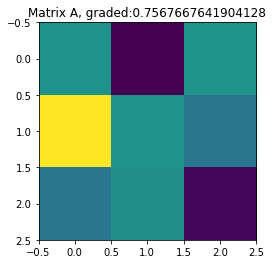


Step 3: proceeding to sk_FastICA ...

A:
 [[ 0.99215813 -0.12212331 -0.026611  ]
 [-0.11349792 -0.96945845  0.21741327]
 [ 0.05234949  0.21268805  0.97571683]]
S average:  [-5.04646829e-19  1.26161707e-19 -1.26161707e-18]
noise average:  [ 2.01070221e-18  1.71106816e-18 -6.74176624e-19]
S cov:
 [[ 1.00000000e+00  2.76688394e-16 -3.73052284e-15]
 [ 2.76688394e-16  1.00000000e+00  1.00310385e-15]
 [-3.73052284e-15  1.00310385e-15  1.00000000e+00]]
I_{k=50}(S): -0.4877816620327722
noise cov:
 [[ 3.34800967e-32  2.99758754e-33  5.25946094e-34]
 [ 2.99758754e-33  3.02583223e-32 -2.31462104e-34]
 [ 5.25946094e-34 -2.31462104e-34  4.96854875e-33]]
X cov:
 [[ 1.00000000e+00 -1.17787724e-15 -3.66026653e-15]
 [-1.17787724e-15  1.00000000e+00  8.16621076e-15]
 [-3.66026653e-15  8.16621076e-15  1.00000000e+00]]
cov(AS,noise):
 [[-1.37031733e-16 -5.05601777e-17 -1.66107870e-17]
 [-2.07005085e-17  2.77399799e-17 -1.19130345e-16]
 [-4.13067669e-18  2.26493878e-17 -1.38042670e-17]]


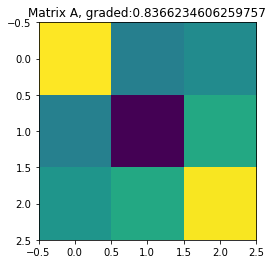

Computing with neighbour-grouping in  4  dimensions...

Step 0: proceeding to sk_FastICA ...

A:
 [[ 0.99536746 -0.06989669  0.04049691 -0.05213511]
 [-0.05574701 -0.95989107 -0.2746188   0.00926901]
 [ 0.07754204  0.22819291 -0.79454582  0.5573259 ]
 [-0.01109592  0.14714474 -0.54003838 -0.82860356]]
S average:  [ 5.55111512e-18 -2.14474902e-18 -2.01858732e-18  2.77555756e-18]
noise average:  [-3.09687566e-18  1.16699579e-18  4.41565976e-19  1.28132984e-20]
S cov:
 [[ 1.00000000e+00 -5.68989300e-16 -3.32373018e-15 -1.33920652e-15]
 [-5.68989300e-16  1.00000000e+00 -4.17721413e-15 -9.08995101e-16]
 [-3.32373018e-15 -4.17721413e-15  1.00000000e+00  4.23272528e-16]
 [-1.33920652e-15 -9.08995101e-16  4.23272528e-16  1.00000000e+00]]
I_{k=50}(S): -0.8614564993404961
noise cov:
 [[ 4.45019536e-32 -9.26152524e-32  1.54225214e-31  1.06712995e-31]
 [-9.26152524e-32  7.75735124e-30 -1.33764363e-29 -1.20279283e-29]
 [ 1.54225214e-31 -1.33764363e-29  2.31293848e-29  2.07464056e-29]
 [ 1.06712995e

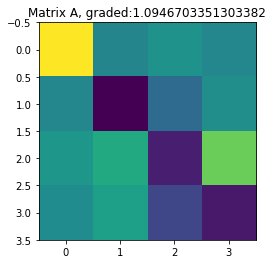


Step 1: proceeding to sk_FastICA ...

A:
 [[ 0.99537183  0.06763837 -0.04541996 -0.05096066]
 [-0.05155877  0.96000778  0.27424688  0.02270238]
 [ 0.0809619  -0.22866424  0.76643069  0.594762  ]
 [-0.00466636 -0.14670643  0.5790593  -0.8019637 ]]
S average:  [ 4.54182146e-18  5.04646829e-18  3.53252781e-18 -3.02788098e-18]
noise average:  [-6.60377687e-19 -1.07237451e-18 -1.54548091e-18  1.46367293e-18]
S cov:
 [[ 1.00000000e+00  5.27355937e-16  3.30638295e-15 -1.17961196e-15]
 [ 5.27355937e-16  1.00000000e+00 -4.31599201e-15  8.67361738e-16]
 [ 3.30638295e-15 -4.31599201e-15  1.00000000e+00 -6.36643516e-16]
 [-1.17961196e-15  8.67361738e-16 -6.36643516e-16  1.00000000e+00]]
I_{k=50}(S): -0.8600139358421246
noise cov:
 [[ 3.57178254e-32  2.91840624e-33 -1.55515167e-31  3.08165089e-31]
 [ 2.91840624e-33  1.08192069e-31  7.68752117e-31 -1.68771742e-30]
 [-1.55515167e-31  7.68752117e-31  1.91399079e-29 -4.00022647e-29]
 [ 3.08165089e-31 -1.68771742e-30 -4.00022647e-29  8.39343219e-29]]
X

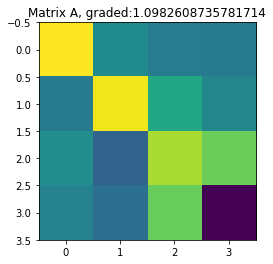


Step 2: proceeding to sk_FastICA ...

A:
 [[ 0.99547179 -0.04486045  0.0653502   0.05246722]
 [-0.054646    0.17283628  0.98264632 -0.03934006]
 [ 0.07700933  0.78640911 -0.15774796 -0.59223801]
 [-0.01092227  0.59133398 -0.07246474  0.80309009]]
S average:  [ 3.02788098e-18  3.53252781e-18 -1.51394049e-18 -5.55111512e-18]
noise average:  [-4.02731825e-18  4.39988954e-18 -2.52323415e-18  1.08518781e-18]
S cov:
 [[ 1.00000000e+00  3.29250516e-15  9.57567359e-16  1.34614542e-15]
 [ 3.29250516e-15  1.00000000e+00 -5.48172618e-15  8.51749227e-16]
 [ 9.57567359e-16 -5.48172618e-15  1.00000000e+00 -7.87564458e-16]
 [ 1.34614542e-15  8.51749227e-16 -7.87564458e-16  1.00000000e+00]]
I_{k=50}(S): -0.8320692897674626
noise cov:
 [[ 3.25071306e-32  1.65407649e-32 -4.79303846e-32  1.01908408e-31]
 [ 1.65407649e-32  4.48788102e-31 -1.76592757e-30  3.92427706e-30]
 [-4.79303846e-32 -1.76592757e-30  7.32047066e-30 -1.62758619e-29]
 [ 1.01908408e-31  3.92427706e-30 -1.62758619e-29  3.63422330e-29]]
X

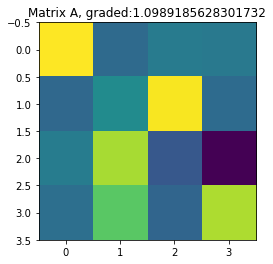


Step 3: proceeding to sk_FastICA ...

A:
 [[ 0.99389663 -0.0850553   0.03653032 -0.06000511]
 [-0.07131502 -0.95961738 -0.27178172  0.01354061]
 [ 0.08263978  0.22344004 -0.78191456  0.57606843]
 [-0.01594727  0.14823842 -0.5598302  -0.81508356]]
S average:  [-2.01858732e-18 -7.19121732e-18  1.76626390e-18 -3.02788098e-18]
noise average:  [-1.30301388e-18  5.96114067e-18 -1.82934476e-18 -1.09110164e-18]
S cov:
 [[ 1.00000000e+00 -4.99600361e-16 -3.42087469e-15 -1.31492039e-15]
 [-4.99600361e-16  1.00000000e+00 -4.19803081e-15 -9.50628465e-16]
 [-3.42087469e-15 -4.19803081e-15  1.00000000e+00  4.33680869e-16]
 [-1.31492039e-15 -9.50628465e-16  4.33680869e-16  1.00000000e+00]]
I_{k=50}(S): -0.8584367010266072
noise cov:
 [[ 3.97725338e-32  2.51563998e-33 -3.60925769e-32 -8.60739759e-32]
 [ 2.51563998e-33  1.08913604e-30  3.71458715e-30  5.63950920e-30]
 [-3.60925769e-32  3.71458715e-30  1.55227993e-29  2.42065193e-29]
 [-8.60739759e-32  5.63950920e-30  2.42065193e-29  3.79441133e-29]]
X

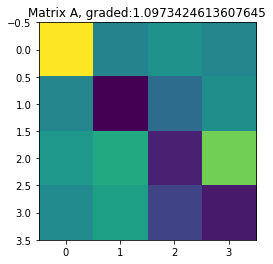

Computing with neighbour-grouping in  5  dimensions...

Step 0: proceeding to sk_FastICA ...

A:
 [[ 0.02223561 -0.99207396 -0.07447693  0.05225613 -0.08376948]
 [-0.42668372 -0.0387281   0.83694622  0.21218062 -0.26634854]
 [-0.8467545  -0.04481917 -0.24675234 -0.36002406  0.30082223]
 [-0.17888342  0.02250806 -0.18586678  0.87930125  0.39972111]
 [-0.26163737  0.10850819 -0.44557944  0.22239756 -0.81961585]]
S average:  [ 3.40636610e-18  1.51394049e-18 -2.52323415e-18 -1.51394049e-18
 -3.91101293e-18]
noise average:  [-8.37299769e-19  1.19853622e-18 -1.11968515e-18  5.67727683e-19
 -4.52605125e-18]
S cov:
 [[ 1.00000000e+00 -1.01828268e-15 -7.78478844e-15 -2.60425362e-15
   1.80324505e-15]
 [-1.01828268e-15  1.00000000e+00 -2.90219238e-15  2.54657406e-15
  -3.94909799e-15]
 [-7.78478844e-15 -2.90219238e-15  1.00000000e+00 -1.53674816e-15
   1.10827146e-15]
 [-2.60425362e-15  2.54657406e-15 -1.53674816e-15  1.00000000e+00
   1.48600750e-15]
 [ 1.80324505e-15 -3.94909799e-15  1.1082714

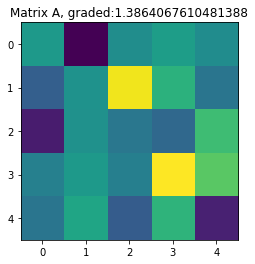


Step 1: proceeding to sk_FastICA ...

A:
 [[ 0.01983536  0.37288333  0.8521881  -0.29436297 -0.21838148]
 [-0.4205497  -0.15056386 -0.27120144 -0.48292876 -0.70263651]
 [-0.85002987  0.386339   -0.01152909  0.16202712  0.31907004]
 [-0.17859925 -0.59323667  0.21088649 -0.54319519  0.5259643 ]
 [-0.26133512 -0.58060397  0.39448599  0.5990129  -0.28313836]]
S average:  [-6.68657049e-18  2.52323415e-18  2.52323415e-18 -1.26161707e-18
 -1.64010220e-18]
noise average:  [-1.63763810e-18 -7.88510671e-20 -1.73472348e-19 -2.39707244e-18
  2.22360009e-18]
S cov:
 [[ 1.00000000e+00  2.33840725e-15  3.61169428e-15  4.42354486e-15
   6.10687716e-15]
 [ 2.33840725e-15  1.00000000e+00  1.25593980e-15 -1.94809446e-15
  -2.96637714e-15]
 [ 3.61169428e-15  1.25593980e-15  1.00000000e+00 -9.62771529e-16
  -7.91901267e-16]
 [ 4.42354486e-15 -1.94809446e-15 -9.62771529e-16  1.00000000e+00
  -1.70675106e-15]
 [ 6.10687716e-15 -2.96637714e-15 -7.91901267e-16 -1.70675106e-15
   1.00000000e+00]]
I_{k=50}(S): 

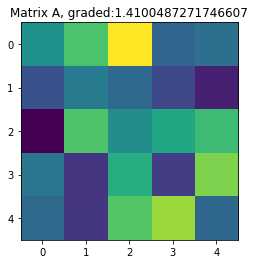


Step 2: proceeding to sk_FastICA ...

A:
 [[-0.95634209  0.24530436  0.05112731 -0.0957753   0.11596843]
 [-0.15859588 -0.41544655  0.06905275  0.85766426  0.24878754]
 [-0.22693775 -0.79360611 -0.37148179 -0.31306335 -0.28754341]
 [-0.0574687  -0.20155955  0.86032317 -0.04332645 -0.46264236]
 [ 0.07384961 -0.31111578  0.33832385 -0.39414878  0.79242471]]
S average:  [-1.00929366e-18  3.09096183e-18 -2.14474902e-18 -3.40636610e-18
  2.52323415e-18]
noise average:  [-2.63510410e-18  2.36553201e-19  1.73472348e-19 -6.93889390e-19
 -2.19205967e-18]
S cov:
 [[ 1.00000000e+00  1.35308431e-16  2.66973943e-15 -4.30612577e-15
   1.02088477e-15]
 [ 1.35308431e-16  1.00000000e+00 -1.77776630e-15 -7.55475293e-15
  -2.65779965e-15]
 [ 2.66973943e-15 -1.77776630e-15  1.00000000e+00 -1.13152760e-15
  -1.39753660e-15]
 [-4.30612577e-15 -7.55475293e-15 -1.13152760e-15  1.00000000e+00
  -2.33713331e-15]
 [ 1.02088477e-15 -2.65779965e-15 -1.39753660e-15 -2.33713331e-15
   1.00000000e+00]]
I_{k=50}(S): 

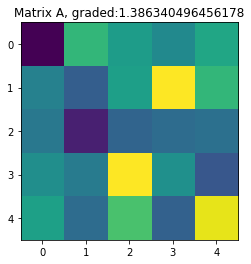


Step 3: proceeding to sk_FastICA ...

A:
 [[ 0.02137918  0.99208506  0.06785728 -0.06508453 -0.08043361]
 [-0.42334427  0.03793912  0.10240952  0.86220319 -0.255848  ]
 [-0.84942522  0.0441573  -0.33330094 -0.29694376  0.2779601 ]
 [-0.17614389 -0.02275647  0.87213395 -0.05477449  0.45258989]
 [-0.26033189 -0.10890427  0.33645288 -0.40148949 -0.80372434]]
S average:  [-1.89242561e-18  2.52323415e-18  2.52323415e-18  7.63278329e-18
 -3.28020439e-18]
noise average:  [ 1.60166230e-19  3.93466825e-18  2.22360009e-18 -7.56970244e-19
 -1.49817027e-18]
S cov:
 [[ 1.00000000e+00  1.00960906e-15 -1.46844342e-15 -8.27387204e-15
   1.29345319e-15]
 [ 1.00960906e-15  1.00000000e+00 -3.07046055e-15  2.52478160e-15
   1.49793372e-15]
 [-1.46844342e-15 -3.07046055e-15  1.00000000e+00 -6.96328845e-16
   1.22818422e-15]
 [-8.27387204e-15  2.52478160e-15 -6.96328845e-16  1.00000000e+00
   2.56426011e-15]
 [ 1.29345319e-15  1.49793372e-15  1.22818422e-15  2.56426011e-15
   1.00000000e+00]]
I_{k=50}(S): 

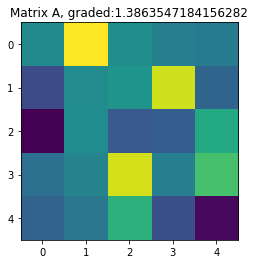

In [35]:
steps = 4

# Specifying the proxy to use:
target = standardize(obs_avg)

# Specify the range of dimensions to explore
target_source_num = list(range(2,6))
#%%capture
def ICA_try(l):
    print('Computing with neighbour-grouping in ',l, ' dimensions...')
    try:
        return CustomICA(whiten(mean(avg_dim_reductor(d, l).dot(rv))[0])[0],
                         noise_fraction=10/100,
                         verbose=True, 
                         constraints=['less-entropy'],
                         num_sources=l,
                         schedule=steps*[sk_FastICA],
                         schedule_kwargs=steps*[{'max_iter':1000, 'algorithm':'deflation'}],
             
                         skip_exception=False)
    except Exception as error:
        print(error)
        pass

    
ICA_trys = [ICA_try(l) for l in target_source_num]

postProcess = PostProcess(ICA_trys, target)

In [23]:
for _ in range(10):
    ICA_trys += [ICA_try(l) for l in target_source_num]
    
postProcess = PostProcess(ICA_trys, target)

Computing with neighbour-grouping in  2  dimensions...
Computing with neighbour-grouping in  3  dimensions...
Computing with neighbour-grouping in  4  dimensions...
Computing with neighbour-grouping in  5  dimensions...
Computing with neighbour-grouping in  2  dimensions...
Computing with neighbour-grouping in  3  dimensions...
Computing with neighbour-grouping in  4  dimensions...
Computing with neighbour-grouping in  5  dimensions...
Computing with neighbour-grouping in  2  dimensions...
Computing with neighbour-grouping in  3  dimensions...
Computing with neighbour-grouping in  4  dimensions...
Computing with neighbour-grouping in  5  dimensions...
Computing with neighbour-grouping in  2  dimensions...
Computing with neighbour-grouping in  3  dimensions...
Computing with neighbour-grouping in  4  dimensions...
Computing with neighbour-grouping in  5  dimensions...
Computing with neighbour-grouping in  2  dimensions...
Computing with neighbour-grouping in  3  dimensions...
Computing 

### Grading an ICA output

Over our different run we must have ICA giving a ${RV}_{signal}$ that is not relevant enough. 
We will grade our ICA using our proxy. If the correlation between our source estimator $\hat S = (\hat S^{(1)},...,\hat S^{(l)})$  and $RV_{proxy}$ is greater than a certain value $\eta$ we will keep it :
If we note ${RV}_{found}$ = $\textit{Find}(\hat S^{(j)},RV_{proxy})$ 

$$ Grade({RV}_{found},{RV}_{proxy}) = \left\{
    \begin{array}{ll}
        \ 1 & \mbox{if}\ |Cov({RV}_{signal},{RV}_{proxy})| > \eta\\
        \ 0 & \mbox{otherwise}. 
    \end{array}
\right. $$


Hence our predictor is : $$\widehat{{RV}_{planet}} =\frac{1}{\sum_{i=1}^n  Grade({RV}_{found},{RV}_{proxy})} \sum_{i=1}^n  Grade({RV}_{found},{RV}_{proxy}){RV}_{found}$$


In [24]:
eta = 0.93
def threshold_grading(target_corr, entropy):
    '''A way to grade an ICA run only using the correlation between the identified source and the proxy'''
    if abs(target_corr)<eta:
        return 0
    else:
        return 1

Guess out of 2 sources, epoch=176 relative error:  0.9665317309812957 %  SNR:  103.4627180821808
Guess out of 3 sources, epoch=176 relative error:  1.1165072917420342 %  SNR:  89.56502186741179
Guess out of 4 sources, epoch=176 relative error:  0.995299891949097 %  SNR:  100.47223033870715
Guess out of 5 sources, epoch=176 relative error:  2.7166307573480073 %  SNR:  36.81030251517164
Guess full, epoch=176 relative error:  0.9581547288075329 %  SNR:  104.36727701010727
Guess best, epoch= 176  cov= 0.9975834332365296  entropy= 0.029978091707508005  relative error:  0.8074912212413224 %  SNR:  123.84035562179139
Target relative error:  1.3374179635438832 %  SNR:  74.77094126582578


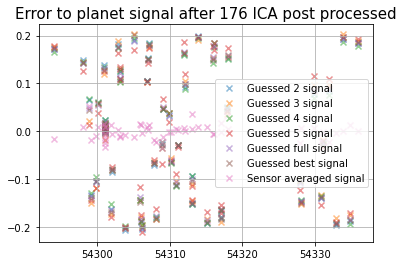

In [25]:
fig = postProcess.investigate(standardize(newtheo),
                              plot_timeline=newtimeline, plot_title='planet',
                              amplifier=threshold_grading)

In [26]:
np.average([116.42198983401136,83.57557159767788,63.920948025717585,38.788583863882806])

75.6767733303224

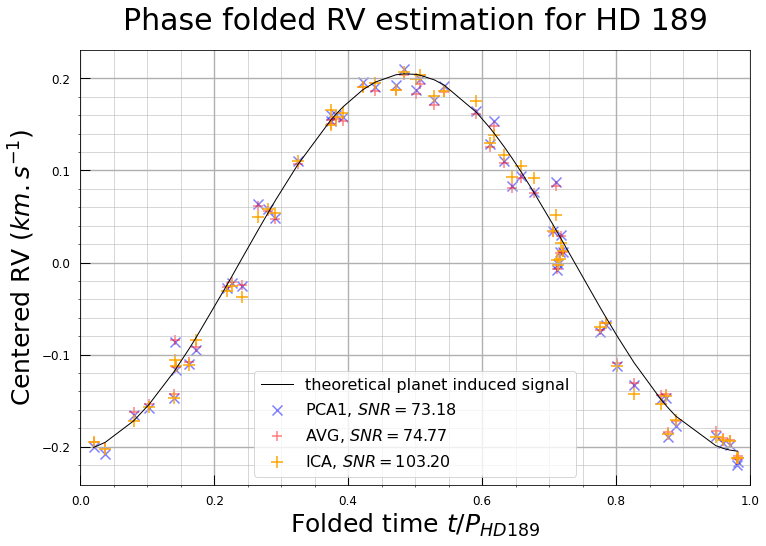

In [27]:
#need great amount of data to run

ICA_res = postProcess.post_process(amplifier=threshold_grading)
#On corrige avec le facteur
ICA_res *= np.array(metadata['RV theo'])[ind].dot(np.array(metadata['RV theo'])[ind]) \
           * 1 / np.array(metadata['RV theo'])[ind].dot(ICA_res)

#Comparaison des différents SNR
alpha = 0.5
phase = 0.04
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_yticks(np.linspace(-.22,.2,22), minor=True)
ax.set_xticks(np.linspace(0,1,21), minor=True)
plt.grid(True, which='minor', linewidth=0.5)
plt.grid(True, which='major', linewidth=1.4)
plt.xlim(0,1)
plt.tick_params(length=10, width=1, direction='in', pad=10, labelsize='large')
inds = np.argsort((newtimeline/period + phase) % 1)
plt.plot(((newtimeline/period + phase)% 1 )[inds], np.array(metadata['RV theo'])[ind][inds], linewidth=1, color='black', label=r'theoretical planet induced signal')
plt.scatter((newtimeline/period + phase)%1, PCA1, s=100, color='blue', marker='x', alpha=alpha,\
            label=r'PCA1, $SNR={:.2f}$'.format(SNR(standardize(np.array(metadata['RV theo'])[ind]), standardize(PCA1))))
plt.scatter((newtimeline/period + phase)%1, obs_avg, s=100, color='red', marker='+', alpha=alpha, \
            label=r'AVG, $SNR={:.2f}$'.format(SNR(standardize(np.array(metadata['RV theo'])[ind]), standardize(obs_avg))))
plt.scatter((newtimeline/period + phase)%1, ICA_res, s=150, color='orange', marker='+', alpha=1, \
            label=r'ICA, $SNR={:.2f}$'.format(SNR(np.array(metadata['RV theo'])[ind], ICA_res)))
#plt.errorbar(t/period % 1, obs_avg, 10**-1*np.average(sigma, axis=0)/sigma.shape[0]**.5, fmt='o')
plt.ylabel(r'Centered RV $(km.s^{-1})$', fontsize=25)
plt.legend(fontsize=16)
plt.xlabel(r'Folded time $t/P_{HD189}$', fontsize=25)
plt.title(r'Phase folded RV estimation for HD 189', fontsize=30, pad=20)
#plt.savefig('HD189_phase_fold.png', dpi=200)
plt.show()

#### Some Commentaries

For each choice of reduction we run ***steps*** time an ICA so we get ***steps*** couple of matrix (A,S). The number **epochs** refer to the total number of such couple, in our case 10 x ***steps*** x ***number of dimension tested*** = 10x6x5 = 330

For each dimension reduction we get a **SNR** result which is the average of all the SNR we've got

***Guess full*** refers to the **SNR** calculated using grading as explained above.

***Guess best*** refers to ?

Let's have a better look to ICA's results. 
The commande **postProcess.S_results** is a table containing for each reduct dimension $d_i \in {2,3,4,5} $ ***steps*** matrice $S=(S_1,...,S_{d_i})$.
For each $S$ we can extract the planet source using our proxy.
I implemented a little algorithm that for a given $d_i$ return 2 list of SNR of best choice for each matrice $S$ with the theoretical signal and the other the SNR for each matric $S$ with our proxy. 

In [201]:
snr = np.zeros(steps)
d_i = 4
prox = np.zeros(steps)
for i in range(steps):
    covs = postProcess.S_results[d_i][i].dot(newtheo.T)
    ind = np.argmax(abs(covs))
    alpha = np.array(target.dot(np.array(target))) \
        * 1 / postProcess.S_results[d_i][i][ind].dot(np.array(target))
    obs = alpha*postProcess.S_results[d_i][i][ind]
    
    frequency, power = LombScargle(newtimeline, postProcess.S_results[d_i][i][ind-1] ).autopower()
    
    prox[i] = SNR(standardize(target),standardize(obs))
    ind2 = np.argmax(prox)
    snr[i] = SNR(standardize(newtheo),standardize(obs))
 
print('SNR between theoric signal and prediction  : '+ str(snr))
print('SNR between proxy signal and prediction :' +str(prox))


SNR between theoric signal and prediction  : [54.35446242 52.10893275 60.68222462 67.08091979]
SNR between proxy signal and prediction :[327.73345527 272.99667613  82.28316714 159.11156837]


#### Remark1 : We can note that in pratice there is only one component with a strong covariance with our proxy so this is clearly a strong way to determine the interesting component.

#### Remark2 : We can remark that the Matrice S which maximizes the SNR with our proxy is not necessary the same as the one which maximizes the SNR with theoric signal.

## Let's work without proxy !

So now that we have seen how to perform an ICA using a proxy we should look for another method. 
One can say that using a blind proxy is not 'cheating' because we are note using an exterior knowledge (proxy is built only with datas). 

However by using average or principal component as a proxy we are assuming that the signal we are looking for is stronger that everyone else and is the most influent in our dataset. 
This should work for big exoplanets such as HD189733 b but with smaller exoplanets we can expect that it fails.

For this reason we will adopt another strategy based on the idea that the component we are looking for is the one with more periodicity over our timeline.

## Analyze through one run

We will use a python package astropy and the function LombScargle which is a powerful tool to measure periodicity.

In [202]:
from astropy.timeseries import LombScargle

In [215]:
d_out = 2
red = avg_dim_reductor(d, d_out)
rv_w, Whiten_mat, Whiten_mat_inv, eigs_RY_2 = whiten(red.dot(rv))

customICA = CustomICA(rv_w,
                      noise_fraction=10/100,
                      verbose=False, 
                      constraints=['less-entropy'],
                      schedule=[sk_FastICA],
                      schedule_kwargs=[{'max_iter':1000, 'algorithm':'deflation'}],
                      skip_exception=False)

S_hat = customICA.result_traceback[-1]['S']
 

To determine which vector has the most periodicity we can use the **false alarm probability**

La fonction **findsource** for a given vector $\hat S = (\hat S_1, ..., \hat S_{d_{out}})$  returns : 
- $\hat S_i = \widehat {{RV}_{planet}}$
- $d_{out}$ : the number of sources
- $i$ : the indice of the good source
- $freq$ : the frequency of the signal

In [216]:
#renvoie le vecteur S_i corrigé du facteur alpha
def alphacorr(S_hat_i, target):
    return (np.array(target.dot(np.array(target))) *1 / S_hat_i.dot(np.array(target))*S_hat_i)

#renvoie la mesure de dispersion (on peut remarquer qu'empiriquement dispersion et false alarm probability jouent le même rôle)
def dispersion(power):
    return(sum(power)/((max(power)-min(power))**2))



def findsource(S_hat) :
    d_out = len(S_hat)
    ls = LombScargle(newtimeline, S_hat[0])
    frequency, power = LombScargle(newtimeline,S_hat[0]).autopower(minimum_frequency=0.001,
                                                       maximum_frequency=1.9,samples_per_peak=100)
    proba = ls.false_alarm_probability(power.max()) 
    ind = 0
    freq = frequency[np.argmax(power)]
    
    for i in range(1,d_out):
        ls = LombScargle(newtimeline, S_hat[i])
        frequency, power = LombScargle(newtimeline,S_hat[i]).autopower(minimum_frequency=0.001,
                                                       maximum_frequency=1.9,samples_per_peak=100)
        
    
        if ls.false_alarm_probability(power.max())<proba:
            ind = i
            proba = ls.false_alarm_probability(power.max())
            freq = frequency[np.argmax(power)]
    
    #print('nombre de sources : ' +str(d_out), 'indice de la bonne source : '+str(ind))
    RV_hat =  S_hat[ind]
    return(RV_hat,d_out, ind, freq)



In [217]:
findsource(S_hat)

(array([-0.17378244, -0.14309919, -0.04179515,  0.13999505,  0.10426604,
        -0.05982394, -0.12624182, -0.00479425,  0.00389721, -0.00629587,
        -0.01645526, -0.01354154,  0.16781615,  0.07760755, -0.1749247 ,
        -0.12951923, -0.10895981,  0.2009618 , -0.20274514,  0.14673831,
         0.18616511,  0.19868453, -0.10597934, -0.15129287, -0.18027247,
         0.06482391,  0.18262643,  0.02934385, -0.04730155, -0.03878284,
         0.06266962,  0.11132562,  0.02767108, -0.16430682, -0.0987176 ,
         0.14966976,  0.10435579, -0.19559565,  0.18929347, -0.14965589,
        -0.18429874,  0.16380678,  0.18269731, -0.0425336 , -0.15901507,
         0.10306978,  0.14953456, -0.0855942 ,  0.13602038,  0.02082492,
        -0.09058468,  0.19174561, -0.19819506,  0.18541284, -0.18691875]),
 2,
 0,
 0.45050954361658174)

In [218]:
SNR(newtheo,standardize(list(np.array(target.dot(np.array(target))) *1 / S_hat[findsource(S_hat)[2]].dot(np.array(target))*S_hat[findsource(S_hat)[2]])))

123.69273430500104

In [219]:
SNR(newtheo,findsource(S_hat)[0])

0.25050630764420345

In [213]:


def cut(i):
    return 2,i//2

def teta(S_hat,newtimeline):
    ls = LombScargle(newtimeline,S_hat)
    frequency, power = LombScargle(newtimeline,S_hat).autopower(minimum_frequency=0.001,
                                                       maximum_frequency=1.9,samples_per_peak=100)
   

    f = frequency[np.argmax(power)]
    teta = ls.model_parameters(f)
    return(teta,f)

def yfit(teta,newtimeline,f):
    smooth_times = np.linspace(newtimeline[0], newtimeline[-1],200)
    y_fit = teta[0]+ teta[1]*np.sin(2*f*np.pi*smooth_times) + teta[2]*np.cos(2*f*np.pi*smooth_times)
    print(len(smooth_times),len(y_fit))
    fi = (smooth_times*2*np.pi*f)%(2*np.pi)
    phi = (newtimeline*2*np.pi*f)%(2*np.pi)
    smooth_preds = np.sin(2*np.pi*smooth_times*f)*0.25
    plt.plot(fi,y_fit,'.')
    plt.scatter(phi,S_hat[i], marker = 'x', color = 'red')
    #plt.plot(smooth_times,smooth_preds)
    return()


    

def visu(S_hat,newtimeline):
    RV_hat,d_out, ind, f = findsource(S_hat)
    
    ls = LombScargle(newtimeline,RV_hat)
    frequency, power = LombScargle(newtimeline,RV_hat).autopower(minimum_frequency=0.001,
                                                       maximum_frequency=1.9,samples_per_peak=100)
   
    
    
    theta = teta(RV_hat,newtimeline)[0]
    ax.plot(frequency, power) 
    smooth_times = np.linspace(newtimeline[0], newtimeline[-1],200)
    y_fit = theta[0]+ theta[1]*np.sin(2*f*np.pi*smooth_times) + theta[2]*np.cos(2*f*np.pi*smooth_times)
    y_fit2 = theta[0]+ theta[1]*np.sin(2*f*np.pi*newtimeline) + theta[2]*np.cos(2*f*np.pi*newtimeline)
    fi = (smooth_times*2*np.pi*f)%(2*np.pi)
    phi = (newtimeline*2*np.pi*f)%(2*np.pi)
    smooth_preds = np.sin(2*np.pi*smooth_times*f)*0.25
    LS = sum((RV_hat-y_fit2)**2)
    plt.figure(figsize=(18,9))
    plt.subplot(132)
    plt.plot(frequency,power)
    plt.ylabel(r'Lombscargle', fontsize=20)
    plt.title(r'periodogram of RV_pl', fontsize=20, pad=20)
    plt.subplot(131)
    plt.plot(fi,y_fit,'.')
    plt.scatter(phi,RV_hat, marker = 'x', color = 'red')
    plt.ylabel(r'Centered RV $(km.s^{-1})$', fontsize=20)

    
    plt.xlabel(r'phase', fontsize=20)
    plt.title(r'normalized yfit of RV_pl', fontsize=20, pad=20)
    plt.subplot(133)
    plt.plot(smooth_times,smooth_preds)
    plt.scatter(newtimeline,RV_hat, marker = 'x', color = 'red')
    plt.title(r'yfit of RV_pl', fontsize=20, pad=20)
    print('Le nombre de sources est : ' +str(d_out))
    print('the period of the planet is : ' + str(1/f))
    print('the SNR is : ' + str(SNR(standardize(newtheo),standardize(RV_hat))))
    print('the Least-Squared is: ' + str(LS))
    



Le nombre de sources est : 2
the period of the planet is : 2.2197088034411916
the SNR is : 0.25050630764420345
the Least-Squared is: 0.0073438743396722125


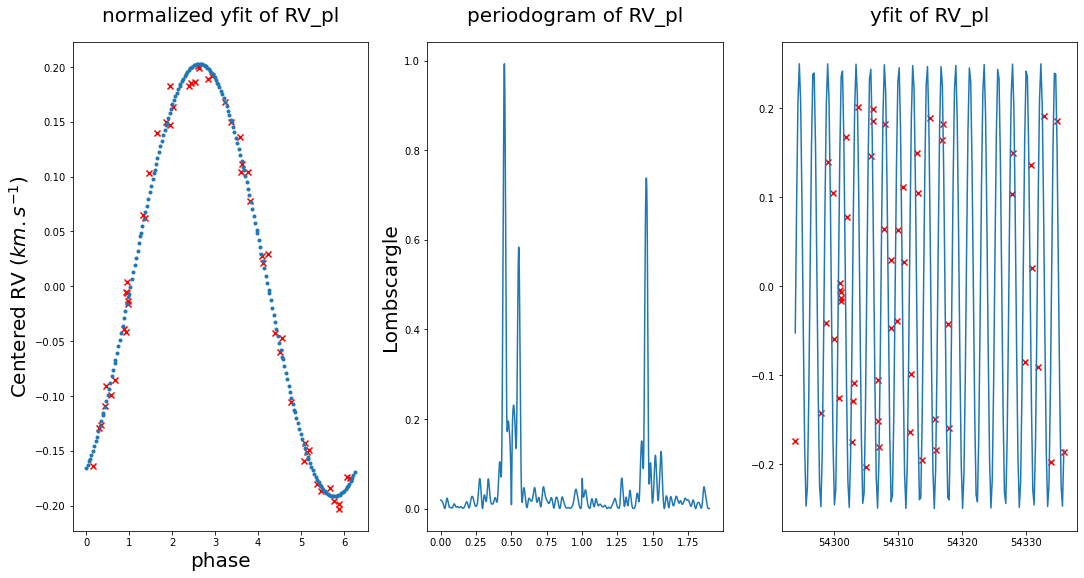

In [220]:
visu(S_hat,newtimeline)

In [94]:
1/freq

NameError: name 'freq' is not defined

200 200


0.44955618297264416

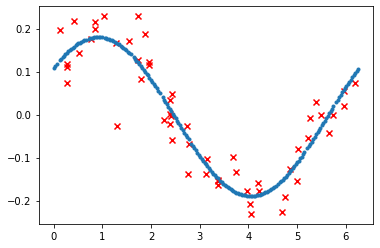

In [334]:


def yfit(teta,newtimeline,f):
    smooth_times = np.linspace(newtimeline[0], newtimeline[-1],200)
    y_fit = teta[0]+ teta[1]*np.sin(2*f*np.pi*smooth_times) + teta[2]*np.cos(2*f*np.pi*smooth_times)
    fi = (smooth_times*2*np.pi*f)%(2*np.pi)
    phi = (newtimeline*2*np.pi*f)%(2*np.pi)
    plt.plot(fi,y_fit,'.')
    plt.scatter(phi,S_hat[3], marker = 'x', color = 'red')
    #plt.plot(smooth_times,smooth_preds)
    return(f)

    
yfit(teta(S_hat[3],newtimeline)[0],newtimeline,teta(S_hat[3],newtimeline)[1])

In [32]:
d_out = 4
red = avg_dim_reductor(d, d_out)
rv_w, Whiten_mat, Whiten_mat_inv, eigs_RY_2 = whiten(red.dot(rv))

customICA = CustomICA(rv_w,
                      noise_fraction=10/100,
                      verbose=False, 
                      constraints=['less-entropy'],
                      schedule=[sk_FastICA],
                      schedule_kwargs=[{'max_iter':1000, 'algorithm':'deflation'}],
                      skip_exception=False)

S_hat = customICA.result_traceback[-1]['S']


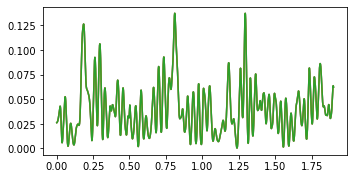

In [317]:
fig = plt.figure(figsize=(12, 6))
frequency, power = LombScargle(newtimeline,S_hat[3]).autopower(minimum_frequency=0.001,
                                                               maximum_frequency=1.9,samples_per_peak=100)
ax = fig.add_subplot(221)


ax.plot(frequency, power)
ax.plot(frequency, power)
ax.plot(frequency, power)
    

Source 1: 0.048265336276431224
Source 2: 0.30186358798049756
Source 3: 1.2160578425018325e-22
Source 4: 0.1759595966172702


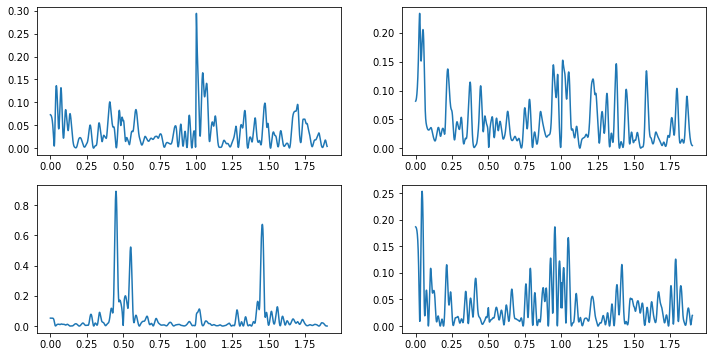

In [93]:
fig = plt.figure(figsize=(12, 6))

for i in range(4):
    ax = fig.add_subplot(2,2,i+1)

    frequency, power = LombScargle(newtimeline,S_hat[i]).autopower(minimum_frequency=0.001,
                                                       maximum_frequency=1.9,samples_per_peak=100)
    ls = LombScargle(newtimeline,S_hat[i])
    f = frequency[np.argmax(power)]

    
    ax.plot(frequency, power)  
    
    print('Source {}: {}'.format(i+1, ls.false_alarm_probability(power.max()))) 

In [270]:
ax = fig.add_subplot(2,2,i)

<ipython-input-270-d3317b905a0b>:1: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(2,2,i)


[ 0.0017927  -0.00172445  0.02125917]
[ 0.00184619 -0.02163378 -0.02304592]
[ 0.00211217 -0.0083089   0.01084221]
[-0.00819612  0.04491714 -0.01338822]
[-0.00784945  0.0369962  -0.02644797]
[-0.0144403   0.0927405   0.00719734]


IndexError: index 6 is out of bounds for axis 0 with size 6

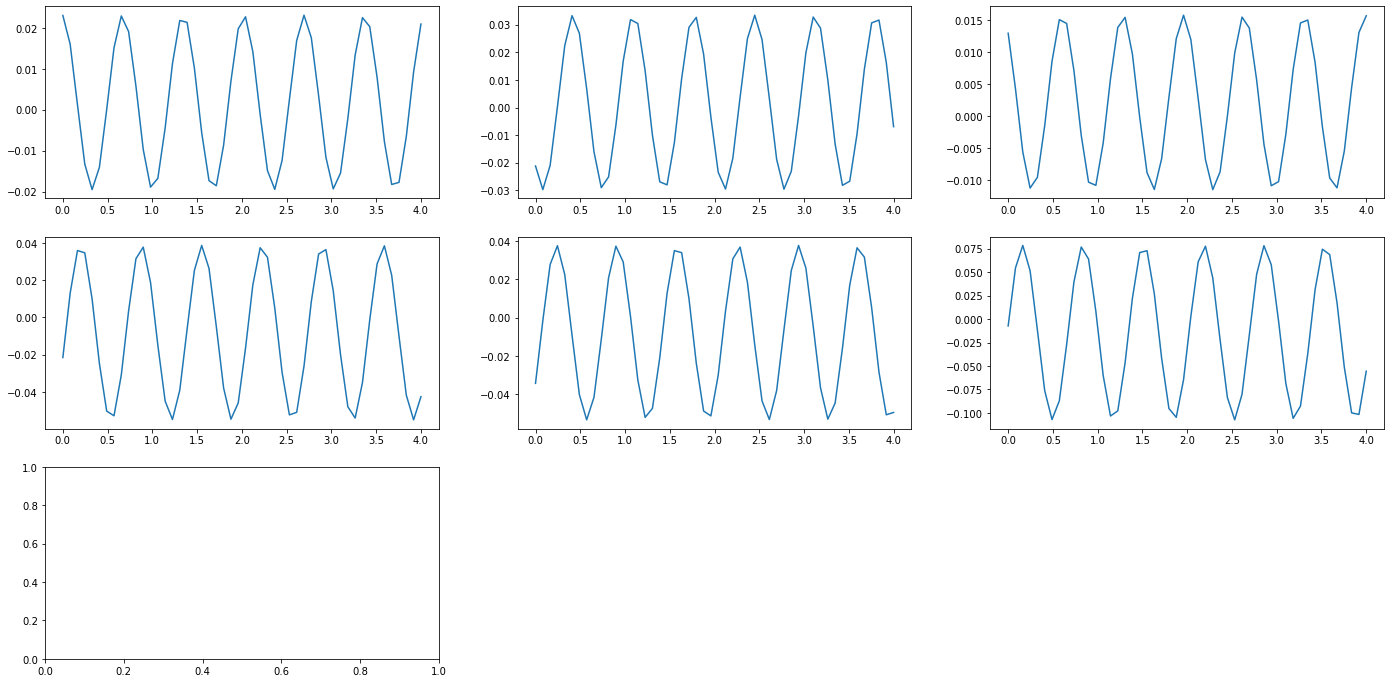

In [343]:
fig = plt.figure(figsize=(24, 12))

for i in range(8):
    ax = fig.add_subplot(3,3,i+1)
    best_frequency = frequency[np.argmax(power)]
    t_fit = np.linspace(0, 4)
    ls = LombScargle(newtimeline,S_hat[i])
    y_fit = ls.model(t_fit, best_frequency)
    theta = ls.model_parameters(best_frequency)
    print(theta)
    ax.plot(t_fit, y_fit) 

